## Last homework

This week we will apply techniques learned during the semester as a recap of the learned methods. We will use a dataset from the paper "Hurricane-induced selection on the morphology of an island lizard", where body parameters of lizards are measured on an island before and after the hurricane. We will make binary predictions if a lizard was measured before of after the hurricane in the upcoming tasks.

When a task is not fully described, try to come up with a reasonable solution!

Data source: https://www.nature.com/articles/s41586-018-0352-3#Sec7

#### 1. Load & prepare data
 - load the provided dataset
 - look for missing values, handle them! Be careful! (You can screw up the whole assignment here)
 - We will make binary predictions if a lizard was before of after the hurricane in the upcoming tasks. 
 - Convert all the features to numeric or binary features.
 - get rid of the ID column

#### 2. T-SNE
 - embed the data points into a 2D space via T-SNE (preprocess the data if needed). For embedding, use only the numerical features (So do not use Sex, Hurricane and Origin features)
 - what is common in the clusters that we got? visualize the embedded points by using different colour for the different fetautre values (eg on a plot show the female gekkos with red and the male ones with blue). Explore at least 4 features! Do we get separation by the Hurricane variable?

#### 3. Linear model + fine-tune
 - train and generate predictions with a logistic regression model using 5 fold cross validation
 - fine-tune the regularization strength for L2 regularization type!
 - show the ROC curve with the AUC value for the best model that you have found

#### 4. SVM + fine-tune
 - train and generate predictions with an SVM model using 5 fold cross validation
 - fine-tune the kernel parameters for 2 selected kernels
 - show the ROC curve with the AUC value for the best model that you have found

#### 5. RF + feature importances
 - train and generate predictions with a random forest classifier model using leave 5 fold cross validation
 - show the ROC curve with the AUC value for the best model that you have found
 - train a random forest model on all the data and show the 5 most important features based on feature importances of the model

### Hints:
 - On total you can get 10 points for fully completing all tasks.
 - Decorate your notebook with, questions, explanation etc, make it self contained and understandable!
 - Comments you code when necessary
 - Write functions for repetitive tasks!
 - Use the pandas package for data loading and handling
 - Use matplotlib and seaborn for plotting or bokeh and plotly for interactive investigation
 - Use the scikit learn package for almost everything
 - Use for loops only if it is really necessary!
 - Code sharing is not allowed between student! Sharing code will result in zero points.
 - If you use code found on web, it is OK, but, make its source clear! 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats

In [2]:
def missing_value_summary(df,df_title="",tpose = True,figsize=[15,6]):
    '''
    tpose - True if the figure should be transposed
    '''
    num_of_na = df.isna().sum(axis=0) #Dict with number of missing features by column
    print("Missing values in {}\n".format(df_title))
    [print(x,":",num_of_na[x]) 
     if num_of_na[x] != 0 
     else None 
     for x in df.columns] # Broken into multiple lines for better readability

    print("\nratio of missing features in the whole table: ", df.isna().sum().sum()/df.count().sum() )
    print("Number of rows: ", df.shape[0])
    
    plt.figure(figsize=figsize)
    if tpose:
        plt.imshow(df.isna().T)
        
    else:
        plt.imshow(df.isna())

# Solution 

## 1. Load & prepare data
 - load the provided dataset
 - look for missing values, handle them! Be careful! (You can screw up the whole assignment here)
 - We will make binary predictions if a lizard was before of after the hurricane in the upcoming tasks. 
 - Convert all the features to numeric or binary features.
 - get rid of the ID column

In [3]:
data = pd.read_csv("Donihue_2018-01-00672_Hurricanes_Data.csv", index_col = "ID")
data.head()

,Hurricane,Origin,Sex,SVL,Femur,Tibia,Metatarsal,LongestToe,Humerus,Radius,...,FingerArea2,FingerArea3,ToeArea1,ToeArea2,ToeArea3,MeanFingerArea,MeanToeArea,SumFingers,SumToes,MaxFingerForce
ID,,,,,,,,,,,,,,,,,,,,,
537,After,Pine Cay,Male,48.69,10.39,11.87,7.52,7.43,8.66,7.99,...,1.338,1.339,2.529,2.402,2.369,1.332667,2.433333,2.663,4.791,0.116
539,After,Pine Cay,Female,40.31,8.66,9.79,6.18,6.20,8.01,6.51,...,0.950,0.972,1.498,1.525,1.530,0.961333,1.517667,2.595,3.678,0.048
540,After,Pine Cay,Male,58.30,12.87,14.76,9.45,9.58,11.72,9.54,...,2.702,2.685,4.157,4.140,3.996,2.631333,4.097667,7.347,4.682,0.424
541,After,Pine Cay,Female,43.15,8.55,10.29,6.60,6.26,7.43,6.60,...,1.175,1.186,1.898,1.871,1.867,1.177667,1.878667,2.786,5.378,0.171
542,After,Pine Cay,Female,45.51,10.26,11.02,6.89,7.02,7.71,7.25,...,1.357,1.420,2.627,2.435,2.529,1.384333,2.530333,3.575,6.646,0.014


Missing values in 

FingerCount : 1
ToeCount : 1
FingerArea1 : 1
FingerArea2 : 1
FingerArea3 : 1
ToeArea1 : 1
ToeArea2 : 1
ToeArea3 : 1
MeanFingerArea : 1
MeanToeArea : 1
SumFingers : 73
SumToes : 73
MaxFingerForce : 74

ratio of missing features in the whole table:  0.059431524547803614
Number of rows:  164


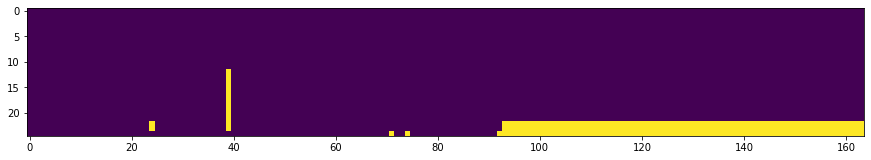

In [4]:
missing_value_summary(data)

By taking a quick look at the data, we can see, that the last 3 columns (SumFingers, SumToes, MaxFingerForce) have values only where the measurement was made after the hurricane. So, by only knowing, that a row has one of these values, it could be  infered, that the measurement was made after the hurricane. Thus, we should get rid of these columns.
<br> Other than that, there is a row, where most of the features is missing. This should be discarded.

In [5]:
data = data.drop(columns = data.columns[-3:])

In [6]:
data = data.dropna(thresh = 20)

Missing values in 


ratio of missing features in the whole table:  0.0
Number of rows:  163


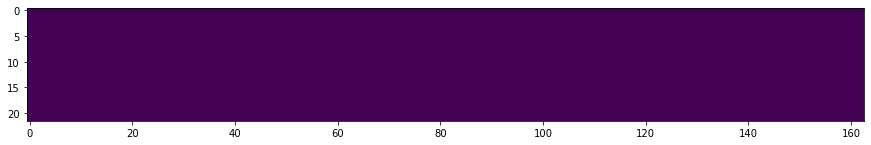

In [7]:
missing_value_summary(data)

In [8]:
y = data["Hurricane"].map(lambda x: 1 if x=="After" else 0 ) #after Hurricane 1, before 0
data = data.drop(columns=["Hurricane"])

In [9]:
x_data = pd.get_dummies(data)

In [10]:
x_data.columns

Index(['SVL', 'Femur', 'Tibia', 'Metatarsal', 'LongestToe', 'Humerus',
       'Radius', 'Metacarpal', 'LongestFinger', 'FingerCount', 'ToeCount',
       'FingerArea1', 'FingerArea2', 'FingerArea3', 'ToeArea1', 'ToeArea2',
       'ToeArea3', 'MeanFingerArea', 'MeanToeArea', 'Origin_Pine Cay',
       'Origin_Water Cay', 'Sex_Female', 'Sex_Male'],
      dtype='object')

## 2. T-SNE
 - embed the data points into a 2D space via T-SNE (preprocess the data if needed). For embedding, use only the numerical features (So do not use Sex, Hurricane and Origin features)
 - what is common in the clusters that we got? visualize the embedded points by using different colour for the different fetautre values (eg on a plot show the female gekkos with red and the male ones with blue). Explore at least 4 features! Do we get separation by the Hurricane variable?

In [11]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_data)
tsne = TSNE(n_components=2)
x = tsne.fit_transform(x_scaled)

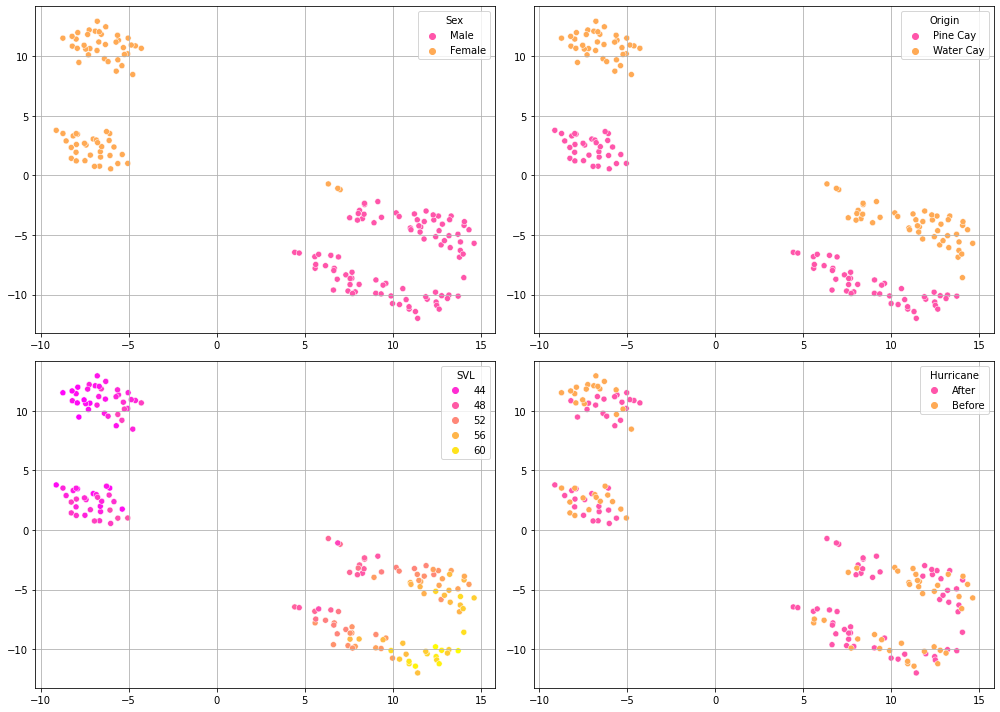

In [12]:
plt.figure(figsize=[14,10])
ax1 = plt.subplot(221)
sns.scatterplot(x = x[:,0], y = x[:,1], hue = data.Sex,palette = "spring", ax= ax1)
plt.grid()

ax2 = plt.subplot(222)
sns.scatterplot(x = x[:,0], y = x[:,1], hue = data.Origin,palette = "spring", ax= ax2)
plt.grid()

ax3 = plt.subplot(223)
sns.scatterplot(x = x[:,0], y = x[:,1], hue = data.SVL,palette = "spring", ax= ax3)
plt.grid()

ax4 = plt.subplot(224)
sns.scatterplot(x = x[:,0], y = x[:,1], hue = y.map(lambda x: "After" if x==1 else "Before" ),palette = "spring", ax= ax4)
plt.grid()

plt.tight_layout()

## 3. Linear model + fine-tune
 - train and generate predictions with a logistic regression model using 5 fold cross validation
 - fine-tune the regularization strength for L2 regularization type!
 - show the ROC curve with the AUC value for the best model that you have found

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logreg = LogisticRegression(n_jobs = -1)
parameters = {"C": np.linspace(1,10,200)}
clf3 = GridSearchCV(logreg, parameters, cv=5)
clf3.fit(x_scaled, y)

print("Best C hyperparameter:")
clf3.best_params_

Best C hyperparameter:


{'C': 2.8542713567839195}

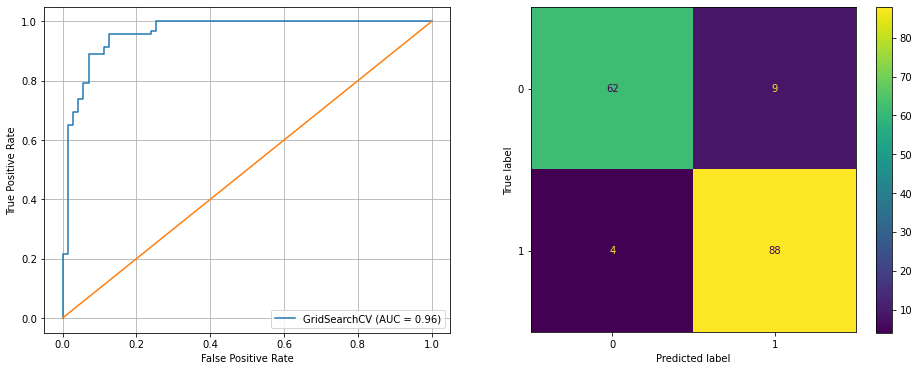

In [14]:
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix

plt.figure(figsize=[16,6])
ax1 = plt.subplot(121)
plot_roc_curve(clf3, x_scaled, y, ax = ax1)
plt.plot(np.linspace(0,1,1000), np.linspace(0,1,1000))
plt.grid()
ax2 = plt.subplot(122)
plot_confusion_matrix(clf3, x_scaled, y, ax = ax2)

## 4. SVM + fine-tune
 - train and generate predictions with an SVM model using 5 fold cross validation
 - fine-tune the kernel parameters for 2 selected kernels
 - show the ROC curve with the AUC value for the best model that you have found

In [15]:
from sklearn.svm import SVC
svc_clf = SVC()
parameters = {"C": np.linspace(0,2,100), "kernel": ("linear", "poly", "rbf", "sigmoid")}
clf4 = GridSearchCV(svc_clf, parameters, cv=5)
clf4.fit(x_scaled, y)

print("Best C hyperparameter:")
clf4.best_params_

Best C hyperparameter:


{'C': 0.10101010101010102, 'kernel': 'linear'}

Text(0.5, 0.98, 'SVM with best parameters')

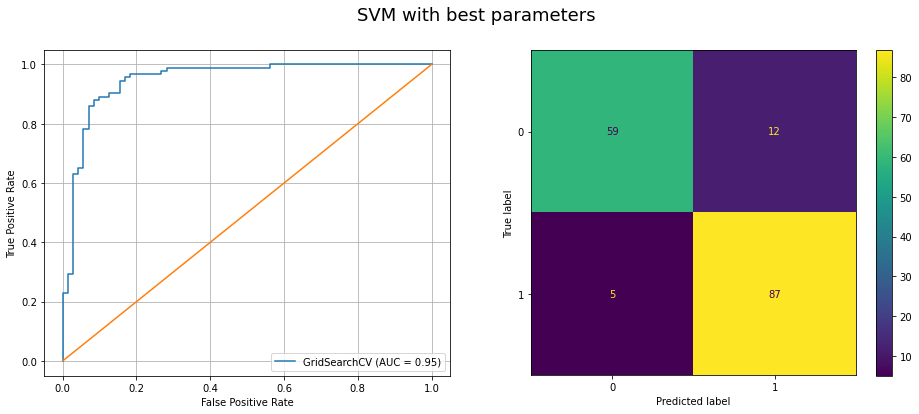

In [16]:
plt.figure(figsize=[16,6])
ax1 = plt.subplot(121)
plot_roc_curve(clf4, x_scaled, y, ax = ax1)
plt.plot(np.linspace(0,1,1000), np.linspace(0,1,1000))
plt.grid()
ax2 = plt.subplot(122)
plot_confusion_matrix(clf4, x_scaled, y, ax = ax2)
plt.suptitle("SVM with best parameters",size=18)

## 5. RF + feature importances
 - train and generate predictions with a random forest classifier model using leave 5 fold cross validation
 - show the ROC curve with the AUC value for the best model that you have found
 - train a random forest model on all the data and show the 5 most important features based on feature importances of the model


In [17]:
from sklearn.ensemble import RandomForestClassifier

In [18]:
from sklearn.model_selection import KFold
clf5 = RandomForestClassifier(n_estimators = 30, n_jobs = -1)

clf5_list = []
clf5_scores = []

kf = KFold(n_splits=5)
for train_index, test_index in kf.split(x_scaled):
    x_train, x_test = x_scaled[train_index], x_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf5.fit(x_train,y_train)
    clf5_list.append(clf5)
    clf5_scores.append(clf5.score(x_test,y_test))

Text(0.5, 0.98, 'SVM with best parameters')

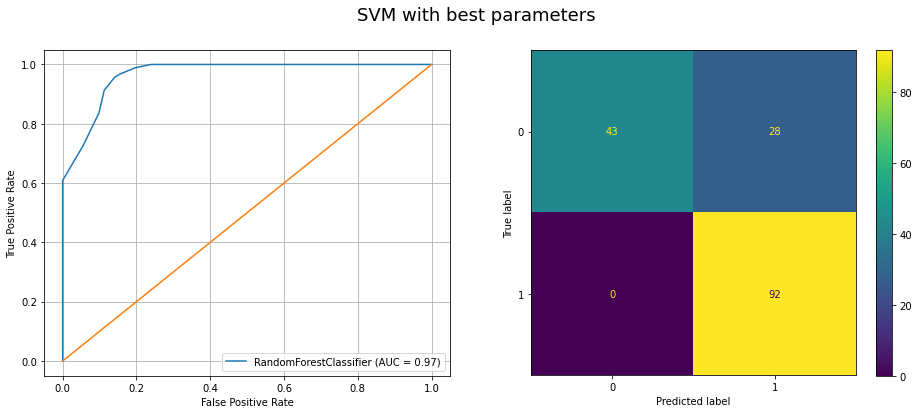

In [19]:
clf5 = clf5_list[np.argmax(clf5_scores)]

plt.figure(figsize=[16,6])
ax1 = plt.subplot(121)
plot_roc_curve(clf5, x_scaled, y, ax = ax1)
plt.plot(np.linspace(0,1,1000), np.linspace(0,1,1000))
plt.grid()
ax2 = plt.subplot(122)
plot_confusion_matrix(clf5, x_scaled, y, ax = ax2)
plt.suptitle("SVM with best parameters",size=18)

In [20]:
[[x,y] for x,y in sorted(zip(clf5.feature_importances_, x_data.columns),reverse= True)]

[[0.12363742972713855, 'Femur'],
 [0.09160724240684742, 'LongestToe'],
 [0.06930775734049782, 'FingerArea3'],
 [0.06749026778313634, 'FingerArea1'],
 [0.060555862397033255, 'MeanFingerArea'],
 [0.05824021954397451, 'Radius'],
 [0.0564071150429746, 'Tibia'],
 [0.054657280866692096, 'Metatarsal'],
 [0.050606998667819945, 'Metacarpal'],
 [0.047359929508804015, 'ToeArea3'],
 [0.04218517412647551, 'SVL'],
 [0.03804599861276496, 'ToeArea2'],
 [0.036169967650517186, 'LongestFinger'],
 [0.0357710237229205, 'FingerArea2'],
 [0.034261812180411765, 'ToeArea1'],
 [0.030823230917818762, 'Origin_Pine Cay'],
 [0.027296314561975194, 'ToeCount'],
 [0.024189462351799588, 'Humerus'],
 [0.02267042689819031, 'MeanToeArea'],
 [0.014470332073459234, 'Origin_Water Cay'],
 [0.012663534481941375, 'FingerCount'],
 [0.001582619136807116, 'Sex_Female'],
 [0.0, 'Sex_Male']]

After taking a look at the five most important features we can summarize, that there are two notable groups of features. One is grip strength, it is signified by the longest toe length and the areas. The other factor is bone length(femur and tibia length). I think the importance of grip strength is self-explanatory. On the other hand, I suppose bone length is important for the reason that lizards with longer legs have to withstand more torque due to wind. Also, lizards with longer have a hard time holding on to a branch during a hurricane, because their center of mass is further away from the branch.